<a href="https://colab.research.google.com/github/wattsr1/Big-Data-Analysis/blob/main/Vine_Review_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backpor

In [ ]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-02-10 21:10:14--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  4.79MB/s    in 0.2s    

2022-02-10 21:10:15 (4.79 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("M16-Amazon-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [ ]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Pet_Products_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   28794885| REAKC26P07MDN|B00Q0K9604|     510387886|(8-Pack) EZwhelp ...|    Pet Products|          5|            0|          0|   N|                Y|A great purchase ...|Best belly bands ...| 2015-08-31|
|         US|   11488901|R3NU7OMZ4HQIEG|B00MBW5O9W|     912374672|Warren Eckstein's...|    Pet Products|          2|    

In [ ]:
# Create the vine_table. DataFrame
vine_df = df.select(["review_id", "star_rating", "helpful_votes", "total_votes", "vine", "verified_purchase"])
vine_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| REAKC26P07MDN|          5|            0|          0|   N|                Y|
|R3NU7OMZ4HQIEG|          2|            0|          1|   N|                Y|
|R14QJW3XF8QO1P|          5|            0|          0|   N|                Y|
|R2HB7AX0394ZGY|          5|            0|          0|   N|                Y|
| RGKMPDQGSAHR3|          5|            0|          0|   N|                Y|
|R1DJCVPQGCV66E|          5|            0|          0|   N|                Y|
|R3V52EAWLPBFQG|          3|            0|          0|   N|                Y|
|R3DKO8J1J28QBI|          2|            0|          0|   N|                Y|
| R764DBXGRNECG|          5|            1|          1|   N|                N|
| RW1853GAT0Z9F|          5|            0|          0|   N|     

In [ ]:
# Filter reviews with more than 20 votes
filtered_ratings_df = vine_df.filter("total_votes>20")
filtered_ratings_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R21KC552Y6HL8X|          1|           27|         31|   N|                Y|
| RX9WC9FTIR1XR|          5|           25|         25|   N|                Y|
| RGDCOU1KBHMNG|          3|           29|         31|   N|                Y|
| RVTYWID2TPMMY|          2|           35|         42|   N|                Y|
|R2CMPZ5VESGRLY|          4|           27|         28|   N|                Y|
|R3VQPJZ54B55BA|          5|           62|         64|   N|                N|
|R24QM6D7FEDZ5M|          2|           36|         43|   N|                Y|
|  R39GSNW76GYF|          1|           20|         23|   N|                Y|
| RPJLR6MFDPXXE|          5|           35|         36|   N|                Y|
|R34X0ZGVB3YGYO|          5|           47|         47|   N|     

In [ ]:
from pyspark.sql.types import IntegerType

# Change rating rows from string to int
filtered_ratings_df = filtered_ratings_df.withColumn("star_rating", filtered_ratings_df["star_rating"].cast(IntegerType()))
filtered_ratings_df = filtered_ratings_df.withColumn("helpful_votes", filtered_ratings_df["helpful_votes"].cast(IntegerType()))
filtered_ratings_df = filtered_ratings_df.withColumn("total_votes", filtered_ratings_df["total_votes"].cast(IntegerType()))

# Create new column with calculated percentage of helpful votes from total votes
filtered_ratings_df = filtered_ratings_df.withColumn("per_helpful_votes",(filtered_ratings_df["helpful_votes"]/filtered_ratings_df["total_votes"]))
filtered_ratings_df.show()

# Create new dataframe with helpful ratings greater than 50%
helpful_ratings_df = filtered_ratings_df.filter("per_helpful_votes>0.5")
# Verify filter by sorting in acsending order
helpful_ratings_df.orderBy(helpful_ratings_df["per_helpful_votes"].asc()).show()

+--------------+-----------+-------------+-----------+----+-----------------+------------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase| per_helpful_votes|
+--------------+-----------+-------------+-----------+----+-----------------+------------------+
|R21KC552Y6HL8X|          1|           27|         31|   N|                Y|0.8709677419354839|
| RX9WC9FTIR1XR|          5|           25|         25|   N|                Y|               1.0|
| RGDCOU1KBHMNG|          3|           29|         31|   N|                Y|0.9354838709677419|
| RVTYWID2TPMMY|          2|           35|         42|   N|                Y|0.8333333333333334|
|R2CMPZ5VESGRLY|          4|           27|         28|   N|                Y|0.9642857142857143|
|R3VQPJZ54B55BA|          5|           62|         64|   N|                N|           0.96875|
|R24QM6D7FEDZ5M|          2|           36|         43|   N|                Y|0.8372093023255814|
|  R39GSNW76GYF|          1|  

In [ ]:
# Create new dataframe containing only with vine program ratings
vine_ratings_df = helpful_ratings_df.filter(helpful_ratings_df["vine"] == "Y")
vine_ratings_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+------------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase| per_helpful_votes|
+--------------+-----------+-------------+-----------+----+-----------------+------------------+
|R3A71VR1JZD8WF|          2|           27|         30|   Y|                N|               0.9|
|R16OMUJIGI18JZ|          5|           72|         72|   Y|                N|               1.0|
|R3TS8ZP2FHQ9XR|          5|           39|         42|   Y|                N|0.9285714285714286|
|R2MHP919VZN7DI|          5|           29|         30|   Y|                N|0.9666666666666667|
|R1JUJLXQ2CMWKF|          4|           25|         26|   Y|                N|0.9615384615384616|
|R2T7YE0IFI6N9L|          3|           24|         25|   Y|                N|              0.96|
|R25FI3J7WWOYXM|          3|           55|         58|   Y|                N|0.9482758620689655|
|R3P3U4EOWIUD50|          3|  

In [ ]:
# Create new dataframe containing only without vine program ratings
non_vine_ratings_df = helpful_ratings_df.filter(helpful_ratings_df["vine"] == "N")
non_vine_ratings_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+------------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase| per_helpful_votes|
+--------------+-----------+-------------+-----------+----+-----------------+------------------+
|R21KC552Y6HL8X|          1|           27|         31|   N|                Y|0.8709677419354839|
| RX9WC9FTIR1XR|          5|           25|         25|   N|                Y|               1.0|
| RGDCOU1KBHMNG|          3|           29|         31|   N|                Y|0.9354838709677419|
| RVTYWID2TPMMY|          2|           35|         42|   N|                Y|0.8333333333333334|
|R2CMPZ5VESGRLY|          4|           27|         28|   N|                Y|0.9642857142857143|
|R3VQPJZ54B55BA|          5|           62|         64|   N|                N|           0.96875|
|R24QM6D7FEDZ5M|          2|           36|         43|   N|                Y|0.8372093023255814|
|  R39GSNW76GYF|          1|  

In [ ]:
# Determine the review count, five star count and percentage 5 star count for vine program ratings
total_ratings = vine_ratings_df.count()
total_five_star = vine_ratings_df.filter("star_rating==5").count()
perc_five_star = (total_five_star/total_ratings)*100

In [ ]:
# Determine the review count, five star count and percentage 5 star count for vine program ratings
total_ratings_non = non_vine_ratings_df.count()
total_five_star_non = non_vine_ratings_df.filter("star_rating==5").count()
perc_five_star_non = (total_five_star_non/total_ratings_non)*100

In [ ]:
# Create dataframe containing summary of vine and non vine ratings
vine_summary_df = spark.createDataFrame([("vine", [total_ratings],[total_five_star],[perc_five_star]),
                                         ("non_vine",[total_ratings_non],[total_five_star_non],[perc_five_star_non])],
                                           ['id', 'Total_Ratings','Total_5_Star_Ratings', 'Percent_5_Star_Ratings'])

vine_summary_df.show()

+--------+-------------+--------------------+----------------------+
|      id|Total_Ratings|Total_5_Star_Ratings|Percent_5_Star_Ratings|
+--------+-------------+--------------------+----------------------+
|    vine|        [162]|                [63]|   [38.88888888888889]|
|non_vine|      [35568]|             [19437]|   [54.64743589743589]|
+--------+-------------+--------------------+----------------------+



+-----------+-----+
|star_rating|count|
+-----------+-----+
|          1|    3|
|          2|   15|
|          3|   27|
|          4|   54|
|          5|   63|
+-----------+-----+



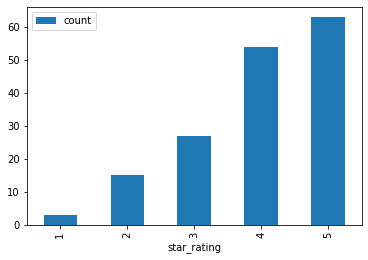

In [ ]:
# Import dependancies
import pandas as pd

# Get counts of all ratings of Vine reviews
vine_rating_totals_df = vine_ratings_df.groupBy("star_rating").count().sort("star_rating")
vine_rating_totals_df.show()

# Plot distribution of ratings using Pandas
plot1 = vine_rating_totals_df.toPandas()
plot1.plot(x='star_rating', y='count', kind='bar')

+-----------+-----+
|star_rating|count|
+-----------+-----+
|          1| 7087|
|          2| 1913|
|          3| 2520|
|          4| 4611|
|          5|19437|
+-----------+-----+



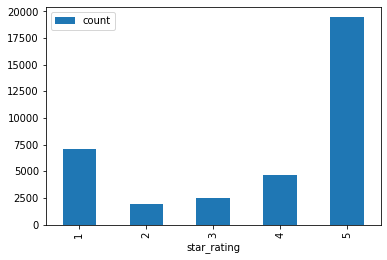

In [ ]:
# Get counts of all ratings of non-Vine reviews
non_vine_rating_totals_df = non_vine_ratings_df.groupBy("star_rating").count().sort("star_rating")
non_vine_rating_totals_df.show()

# Plot distribution of ratings using Pandas
plot1 = non_vine_rating_totals_df.toPandas()
plot1.plot(x='star_rating', y='count', kind='bar')